#### Declarations and definitions

In [1]:
import numpy
import gensim
import math
from gensim.models.word2vec import Word2Vec
from keras import preprocessing
from keras.preprocessing import sequence
from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple
from keras.models import load_model
import statistics
import random
import glob
import os
import datetime
from pathlib import Path
import matplotlib.pyplot as plt

homePath = str(Path.home()) + "/MLClassificationData"
#homePath = "c:/BERT/rtanews/docs/"
LabeledSentence = gensim.models.doc2vec.TaggedDocument
# Count of categories (labels).
n_cats = 0
# This id is included into the names of models, created by this notebook.
modelId = 5
# Path to original corpus for training
trainRoot = homePath + '/train/rtanews/source'
# Path to original corpus for testing
testRoot = homePath + '/test/rtanews/source'
# Input for BERT
bertDataPath = homePath + "/PytorchBERT/textdir/"
# Output of BERT
outDataPath = homePath + "/PytorchBERT/outdir/"
# Path to model info
modelInfoPath = homePath + '/models/rtanews/modelinfo/'
max_bert_seq_length = 512
numpy.random.seed(1)
cnt = 0
nCats = 0
categories = dict()

LabeledDocument = namedtuple('LabeledDocument', 'line words labels qLabs name')

def getCategories(path):
    cats = dict()
    nCats = 0
    os.chdir(path)
    for f in glob.glob("*"):
        if os.path.isdir(f):
            cats[f] = nCats
            nCats += 1
    return cats

def prepareDocsData(path, cats):
    files = dict()
    fInCats = [0] * len(cats)
    nFiles = 0
    actFiles = 0
    curCategory = 0
    docs = []
    os.chdir(path)
    rootDir = os.getcwd()
    for f in glob.glob("*"):
        curCategory = cats[f]
        catPath = path + "/" + f
        os.chdir(catPath)
        for fc in glob.glob("*"):
            actFiles += 1
            if fc not in files:
                nFiles += 1
                fPath = catPath + "/" + fc
                docCont = ''
                with open(fc, 'r', encoding='UTF-8') as tc:
                    for line in tc:
                        docCont += line.strip() + " "
                tc.close()
                line = docCont.strip() + "\n"
                words = docCont.strip().split()
                labels = [0] * len(cats)
                labels[curCategory] = 1
                files[fc] = LabeledDocument(line, words, labels, [1], fc)
            else:
                files[fc].labels[curCategory] = 1
                files[fc].qLabs[0] += 1
            fInCats[curCategory] += 1
    for k, val in files.items():
        docs.append(val)
    return docs, fInCats

def getLabelSets(docs):
    labels = [x[2] for x in docs]
    results = [labels[0]]
    qLabs = 0
    for i in range(len(labels)):        
        if i%1000 == 0:
            print (str(i), end='\r')
        qLabs += sum(labels[i])
        count = 0
        for j in range(len(results)):
            for k in range(len(categories)):
                if labels[i][k] != results[j][k]:
                    count += 1
                    break
        if count == len(results):
            results.append(labels[i])
    return len(results), qLabs
    
def showTime(ds,de):
    result = ''
    seconds = (de-ds).total_seconds()
    if seconds < 1:
        return "less than 1 sec"
    hh = int(seconds/(60*60));
    if hh > 0:
        result = "%d h:"%(hh);
    seconds -= hh*60*60
    mm = int(seconds/60);
    if mm > 0:
        result += "%d min:"%(mm)
    ss = seconds - mm*60;
    result += "%d sec"%(ss)
    return result

def showDocsByLength(plt):
    fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10,6))    
    dictLens = dict()
    dictLens1 = dict()
    for i in range(len(trainDocs)):
        lend = "%5d"%(len(trainDocs[i].words))
        if not lend in dictLens:
            dictLens[lend] = 1
        else:
            dictLens[lend] += 1
    lens = sorted(list(dictLens.items()))
    lvars = [int(x[0]) for x in lens]
    locc = [x[1] for x in lens]
    plot1.set_title ("Documents by length in training set")
    plot1.set_ylabel("Documents")
    plot1.set_xlabel("Length")
    plot1.plot(lvars, locc, "b.-") 
    for i in range(len(testDocs)):
        lend = "%5d"%(len(testDocs[i].words))
        if not lend in dictLens1:
            dictLens1[lend] = 1
        else:
            dictLens1[lend] += 1
    lens1 = sorted(list(dictLens1.items()))
    lvars1 = [int(x[0]) for x in lens1]
    locc1 = [x[1] for x in lens1]
    plot2.set_title ("Documents by length in testing set")
    plot2.set_xlabel("Length")
    plot2.yaxis.tick_right()
    plot2.plot(lvars1, locc1, "b.-") 
    plt.show()
    
def showDocsByLabs(plt):
    fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10,6))
    dictLabs = dict()
    dictLabs1 = dict()
    for i in range(len(trainDocs)):
        lab = "%5d"%(trainDocs[i].qLabs[0])
        if not lab in dictLabs:
            dictLabs[lab] = 1
        else:
            dictLabs[lab] += 1
    labs = sorted(list(dictLabs.items()))
    lvars1 = [int(x[0]) for x in labs]
    locc1 = [x[1] for x in labs]
    plot1.set_title ("Documents by labels in training set")
    plot1.set_ylabel("Documents")
    plot1.set_xlabel("Labels")
    plot1.set_xticks(numpy.arange(0, len(categories), step=1))
    plot1.plot(lvars1, locc1, "bo-")
    for i in range(len(testDocs)):
        lab = "%5d"%(testDocs[i].qLabs[0])
        if not lab in dictLabs1:
            dictLabs1[lab] = 1
        else:
            dictLabs1[lab] += 1
    labs1 = sorted(list(dictLabs1.items()))
    lvars2 = [int(x[0]) for x in labs1]
    locc2 = [x[1] for x in labs1]
    plot2.set_title ("Documents by labels in testing set")
    #plot2.set_ylabel("Documents")
    plot2.set_xlabel("Labels")
    plot2.set_xticks(numpy.arange(0, len(categories), step=1))
    plot2.yaxis.tick_right()
    plot2.plot(lvars2, locc2, "bo-")
    plt.show()

Using TensorFlow backend.


#### Load train and test data

In [2]:
ds = datetime.datetime.now()
categories = getCategories(trainRoot)
#print (categories)
trainAllDocs, fInCats1 = prepareDocsData(trainRoot, categories)
trainAllDocs = random.sample(trainAllDocs, len(trainAllDocs))
#trainDocs = trainAllDocs[:int(len(trainAllDocs) * (1 - valPart))]
#valDocs = trainAllDocs[int(len(trainAllDocs) * (1 - valPart)):]
trainDocs = trainAllDocs
testDocs, fInCats2 = prepareDocsData(testRoot, categories)
#testDocs = random.sample(testDocs, len(testDocs))
de = datetime.datetime.now()

print ("Load input data in %s"%(showTime(ds, de))) 

Load input data in 3 sec


#### Dataset analysis

Dataset properties:
Loaded 23837 documents: 15001 for training, 8836 for test
Length of documents: maximum: 1502, minimum: 47, average: 188, median: 174


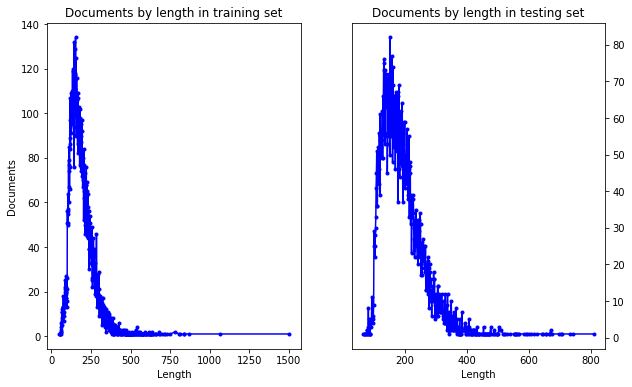

Length of 90.0% documents from training set is less then 300. Longer documents will be truncated.

Categories (labels): 40
Documents for training in category : maximum: 2800, minimum: 93, avegare: 415
Documents for testing  in category : maximum: 1501, minimum: 65, avegare: 276


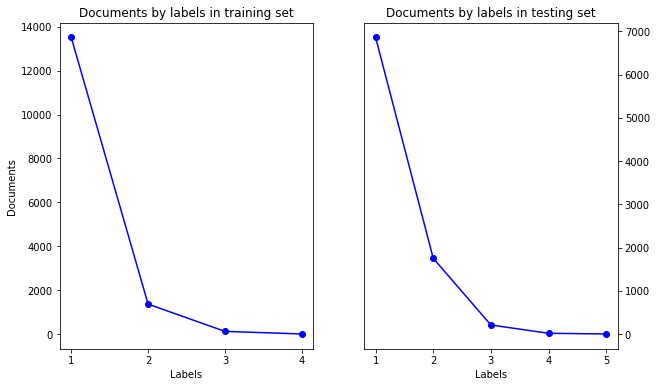

Distinct Label Set: 290
Proportion of Distinct Label Set: 0.0193
Label Cardinality: 1.1073
Label Density: 0.0277


In [3]:
print ("Dataset properties:")
maxDocLen = max(len(x.words) for x in trainAllDocs)
minDocLen = min(len(x.words) for x in trainAllDocs)
avrgDocLen = round(statistics.mean(len(x.words) for x in trainAllDocs), 2)
medianDocLen = round(statistics.median(len(x.words) for x in trainAllDocs), 2)
dls, qLabs = getLabelSets(trainAllDocs)

print ('Loaded %d documents: %d for training, %d for test' % (len(trainAllDocs) + len(testDocs), len(trainDocs), len(testDocs)))
print ("Length of documents: maximum: %d, minimum: %d, average: %d, median: %d"%(maxDocLen, minDocLen, avrgDocLen, medianDocLen))
showDocsByLength(plt);

top_bound=0.9
maxLen = math.ceil(maxDocLen/100)*100 + 100
input_length_list=[]
for i in range(100, maxLen, 100):
    input_length_list.append(i)
input_length_dict={x:0 for x in input_length_list }
for i in range(len(trainAllDocs)):
    curLen = len(trainAllDocs[i].words)
    dictLen = maxLen
    for ln in input_length_dict:
        if curLen < ln:
            dicLen = ln
            break
    input_length_dict[dicLen] = input_length_dict[dicLen] + 1
input_length_dict_percentage={}
for k,v in input_length_dict.items():
    v=v/len(trainAllDocs)
    input_length_dict_percentage[k]=v
maxSeqLength=0
accumulate_percentage=0
for length,percentage in input_length_dict_percentage.items():
    accumulate_percentage+=percentage
    if accumulate_percentage>0.9:
        maxSeqLength=length
        break
print ("Length of %.1f%% documents from training set is less then %d. Longer documents will be truncated."%(top_bound*100, maxSeqLength))        

print ()
print ("Categories (labels): %d"%(len(categories)))
print ("Documents for training in category : maximum: %d, minimum: %d, avegare: %d"%(max(fInCats1), min(fInCats1), round(statistics.mean(fInCats1), 2)))
print ("Documents for testing  in category : maximum: %d, minimum: %d, avegare: %d"%(max(fInCats2), min(fInCats2), round(statistics.mean(fInCats2), 2)))
showDocsByLabs(plt)
print ("Distinct Label Set: %d"%(dls))
print ("Proportion of Distinct Label Set: %.4f"%(dls/len(trainAllDocs)))
print ("Label Cardinality: %.4f"%(qLabs/len(trainAllDocs)))
print ("Label Density: %.4f"%(qLabs/len(trainAllDocs)/len(categories)))

#del trainAllDocs

#### Prepare input for training and testing BERT

In [4]:
cNames = [''] * len(categories)
for k,v in categories.items():
    cNames[v] = k
    
def saveData(type):
    global bertDataPath
    if type == "train":
        bertPath = bertDataPath + "train.tsv"
        data = trainDocs        
    else:
        bertPath = bertDataPath + "dev.tsv"
        data = testDocs        
    target = open(bertPath, "w", encoding="utf-8")
    for i in range(len(data)):
        conts = data[i].line.replace('\r','').replace('\n','.')
        labs = []
        for j in range(len(data[i].labels)):
            if data[i].labels[j] == 1:
                #labs.append(cNames[j].replace(".",""))
                labs.append(cNames[j])
        nl = '\n'
        if i == 0:
            nl = ''
        string = nl + ",".join(labs) + "\t" + conts
        target.write(string)
    target.close()    
    
saveData("train")
print ("Train data saved")
saveData("test")
print ("Test data saved")

Train data saved
Test data saved


In [5]:
from pytorch_pretrained_bert.modeling import BertModel
from pytorch_pretrained_bert.modeling import PreTrainedBertModel
from torch import nn
from torch.nn import BCEWithLogitsLoss

class BertForMultiLabelSequenceClassification(PreTrainedBertModel):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    """
    def __init__(self, config, num_labels=2):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return logits
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


#### Create, train, save and test model

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import os
import logging
import argparse
import random
from tqdm import tqdm, trange

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) [string]. The labels of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""
    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

class DataProcessor(object):
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding='utf-8') as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines

    def get_train_examples(self, data_dir):
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        labels_list = []
        cNames = [''] * len(categories)
        for k,v in categories.items():
            labels_list.append(k)
        return labels_list

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[1]
            text_b = None
            label = line[0]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = [0] * len(categories)
        exLabels = example.label.split(",")
        for i in range(len(exLabels)):
            label_id[label_map[exLabels[i]]] = 1
            
        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

def accuracy(y_pred, y_true, thresh:float=0.5):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    y_pred = y_pred.sigmoid()
    return np.mean(((y_pred>thresh)==y_true.byte()).float().cpu().numpy(), axis=1).sum()

max_bert_seq_length = 512
class Args(object):
    def __init__(self, bert_model):
        self.bert_model = bert_model
    

args = Args("bert-base-multilingual-cased")
args.data_dir = bertDataPath
args.bert_model = "bert-base-multilingual-cased"
args.output_dir = outDataPath
args.max_seq_length = min(max_bert_seq_length, maxSeqLength)
args.do_train = True
args.do_eval = True
args.do_lower_case = False
args.train_batch_size = 32
args.eval_batch_size = 8
args.learning_rate = 5e-5
args.num_train_epochs = 3
args.warmup_proportion = 0.1
args.no_cuda = True
args.local_rank = -1
args.seed = 42
args.gradient_accumulation_steps = 1

device = 'cpu'
n_gpu = torch.cuda.device_count()
args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if not args.do_train and not args.do_eval:
    raise ValueError("At least one of `do_train` or `do_eval` must be True.")

if os.path.exists(args.output_dir) and os.listdir(args.output_dir) and args.do_train:
    raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
os.makedirs(args.output_dir, exist_ok=True)

processor = DataProcessor()
num_labels = len(categories)
label_list = processor.get_labels()
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)
train_examples = None
num_train_optimization_steps = None    
if args.do_train:
    train_examples = processor.get_train_examples(args.data_dir)
    num_train_optimization_steps = int(
        len(train_examples) / args.train_batch_size / args.gradient_accumulation_steps) * args.num_train_epochs
model = BertForMultiLabelSequenceClassification.from_pretrained(args.bert_model,
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(args.local_rank),
    num_labels = num_labels)
model.to(device)

#namedParams = [p for p in model.named_parameters()]
#print ("!!! model.named_parameters():")
#print (namedParams)
#param_optimizer = list(model.named_parameters())
param_optimizer = [p for p in model.named_parameters()]
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = BertAdam(optimizer_grouped_parameters,
    lr=args.learning_rate,
    warmup=args.warmup_proportion,
    t_total=num_train_optimization_steps)

global_step = 0
nb_tr_steps = 0
tr_loss = 0

if args.do_train:
    train_features = convert_examples_to_features(
        train_examples, label_list, args.max_seq_length, tokenizer)
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_examples))
    logger.info("  Batch size = %d", args.train_batch_size)
    logger.info("  Num steps = %d", num_train_optimization_steps)
    all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.float)
    train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=args.train_batch_size)
    model.train()
    for _ in trange(int(args.num_train_epochs), desc="Epoch"):
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            loss = model(input_ids, segment_ids, input_mask, label_ids)
            if n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu.
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            loss.backward()
            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1

# Save a trained model
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
output_model_file = os.path.join(args.output_dir, "pytorch_model.bin")
if args.do_train:
    torch.save(model_to_save.state_dict(), output_model_file)

# Load a trained model that you have fine-tuned
model_state_dict = torch.load(output_model_file)
model = BertForMultiLabelSequenceClassification.from_pretrained(args.bert_model, state_dict=model_state_dict, num_labels=num_labels)
model.to(device)

if args.do_eval and (args.local_rank == -1 or torch.distributed.get_rank() == 0):
    eval_examples = processor.get_dev_examples(args.data_dir)
    eval_features = convert_examples_to_features(
        eval_examples, label_list, args.max_seq_length, tokenizer)
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", args.eval_batch_size)
    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.float)
    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    
    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    allLabs = None
    res = None
    initRes = True
    for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader, desc="Evaluating"):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)
        with torch.no_grad():
            tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids, segment_ids, input_mask)
        preds = logits.sigmoid().to('cpu').numpy()
        labs = label_ids.to('cpu').numpy()
        if initRes == True:
            res = preds
            allLabs = labs
            initRes = False
        else:
            res = numpy.concatenate((res, preds))
            allLabs = numpy.concatenate((allLabs, labs))

        tmp_eval_accuracy = accuracy(logits, label_ids)
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_examples
    loss = tr_loss/nb_tr_steps if args.do_train else None
    result = {'eval_loss': eval_loss,
        'eval_accuracy': eval_accuracy,
        'global_step': global_step,
        'loss': loss}
    
    output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))
    writer.close()

    output_pred_file = os.path.join(args.output_dir, "predictions.txt")
    with open(output_pred_file, "w") as writer:
        for i in range(len(res)):
            line = ""
            for j in range(len(allLabs[i])):
                if allLabs[i][j] == 1:
                    if line != '':
                        line = line + ","
                    line = line + str(j)
            for j in range(len(res[i])):
                line = line + "\t"
                line = line + str(res[i][j])
            line = line + "\n"
            writer.write(line)
    writer.close()

02/13/2019 01:16:31 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /home/user/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
02/13/2019 01:16:31 - INFO - __main__ -   LOOKING AT /home/user/MLClassificationData/PytorchBERT/textdir/train.tsv
02/13/2019 01:16:32 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz from cache at /home/user/.pytorch_pretrained_bert/distributed_-1/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9
02/13/2019 01:16:32 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/user/.pytorch_pretrained_bert/distributed_-1/731c19ddf

Iteration:  44%|████▎     | 205/469 [1:53:51<2:26:00, 33.18s/it]


Iteration:  69%|██████▉   | 325/469 [3:02:35<1:18:17, 32.62s/it]


Iteration:  95%|█████████▌| 447/469 [4:12:49<12:47, 34.90s/it]


Iteration:  22%|██▏       | 102/469 [59:48<3:44:32, 36.71s/it]


Iteration:  47%|████▋     | 222/469 [2:10:14<2:21:02, 34.26s/it]


Iteration:  73%|███████▎  | 342/469 [3:20:15<1:10:28, 33.29s/it]


Iteration:  99%|█████████▉| 465/469 [4:29:20<02:19, 34.89s/it]


Iteration:  26%|██▌       | 120/469 [1:08:26<3:21:38, 34.67s/it]


Iteration:  51%|█████     | 240/469 [2:17:38<2:13:46, 35.05s/it]


Iteration:  77%|███████▋  | 360/469 [3:27:34<1:04:30, 35.51s/it]


Epoch: 100%|██████████| 3/3 [13:27:29<00:00, 16095.34s/it] it]
02/13/2019 14:46:23 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz from cache at /home/user/.pytorch_pretrained_bert/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9
02/13/2019 14:46:23 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/user/.pytorch_pretrained_bert/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9 to temp dir /tmp/tmph0jt7mnt
02/13/2019 14:46:32 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position

02/13/2019 14:48:06 - INFO - __main__ -   ***** Running evaluation *****
02/13/2019 14:48:06 - INFO - __main__ -     Num examples = 8836
02/13/2019 14:48:06 - INFO - __main__ -     Batch size = 8
Evaluating: 100%|██████████| 1105/1105 [1:14:02<00:00,  3.50s/it]
02/13/2019 16:02:09 - INFO - __main__ -   ***** Eval results *****
02/13/2019 16:02:09 - INFO - __main__ -     eval_accuracy = 0.9823987112697189
02/13/2019 16:02:09 - INFO - __main__ -     eval_loss = 0.049779869736555744
02/13/2019 16:02:09 - INFO - __main__ -     global_step = 1407
02/13/2019 16:02:09 - INFO - __main__ -     loss = 0.04205471432920712


#### Calculate metrics

In [10]:
print ("Calculate metrics.")
rankThreshold = 0.3
test_labels = allLabs

print("Len of test_labels: %d, results: %d"%(len(test_labels), len(res)))

def rankIndicator(labels, predictions, index):
    global rankThreshold
    #print(len(labels), len(predictions), index)
    return (labels[index] == 1), (predictions[index] >= rankThreshold)
    
def getPrediction(entry):
    return entry[1]

# General results   
tp = 0
fp = 0
fn = 0
qTags = 0
qPreds = 0
for i in range(len(test_labels)):
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if predicted:
            qPreds += 1
            if actual:
                qTags += 1
                tp += 1
            else:
                fp += 1
        else:
            if actual:
                qTags += 1
                fn += 1
print ("Labels actual: %d, predicted: %d, correctly: %d, incorrectly: %d, not predicted: %d"%(qTags, qPreds, tp, fp, fn))

#Exact Match Ratio
wrongPreds = 0
for i in range(len(test_labels)):
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if (actual and not predicted) or (predicted and not actual):
            wrongPreds += 1
            break;
emr = (len(test_labels) - wrongPreds)/len(test_labels)           
print ("Exact Match Ratio:  %.2f%%" % ((len(test_labels) - wrongPreds)/len(test_labels) * 100))

#Accuracy
accuracy = 0.
for i in range(len(test_labels)):
    labels = sum(test_labels[i])
    tp = 0
    tfp = 0
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if actual and predicted:
            tp += 1
        if predicted and not actual:
            tfp += 1
    accuracy += tp / (labels + tfp)
modelAccuracy = accuracy / len(test_labels)
print ("Accuracy:  %.2f%%" % (accuracy / len(test_labels) * 100))  

#Precision
precision = 0.
for i in range(len(test_labels)):
    labels = sum(test_labels[i])
    tp = 0
    tfp = 0
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if actual and predicted:
            tp += 1
    precision += tp / labels
modelPrecision = precision / len(test_labels)
print ("Precision:  %.2f%%" % (precision / len(test_labels) * 100))  

#Recall
recall = 0.
for i in range(len(test_labels)):
    labels = sum(test_labels[i])
    tp = 0
    tfp = 0
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if actual and predicted:
            tp += 1
        if predicted:
            tfp += 1
    if tfp > 0:
        recall += tp / tfp
modelRecall = recall / len(test_labels)      
print ("Recall:  %.2f%%" % (recall / len(test_labels) * 100))  

#F1-Measure
modelF1 = 2 * (modelPrecision * modelRecall / (modelPrecision + modelRecall))
print ("F1-Measure:  %.2f%%" % (2 * (modelPrecision * modelRecall / (modelPrecision + modelRecall)) * 100))

#Hamming Loss
hl = 0.
for i in range(len(test_labels)):
    labels = sum(test_labels[i])
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if (actual and not predicted) or (predicted and not actual):
            hl += 1
modelHl = hl / (len(test_labels) * len(categories))           
print ("Hamming Loss:  %.2f%%" % (hl * 100 / (len(test_labels) * len(categories)))) 

#Macro-Averaged Precision
precision = 0
for i in range(len(categories)):
    tp = 0
    tact = 0
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i) 
        if not actual:
            continue
        tact += 1
        if predicted:
            tp += 1
    precision += tp / tact
modelMacroPrecision = precision / len(categories) 
print ("Macro-Averaged Precision:  %.2f%%" % (precision / len(categories) * 100))  

#Macro-Averaged Recall
recall = 0
for i in range(len(categories)):
    tp = 0
    tact = 0
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i)
        if predicted:
            tact += 1
            if actual:
                tp += 1
    if tact > 0:                
        recall += tp / tact
    #else:
    #    print ("Macro-Recall: category %d isn't predicted"%(i))
modelMacroRecall = recall / len(categories)
print ("Macro-Averaged Recall:  %.2f%%" % (recall / len(categories) * 100))  

#Macro-Averaged F1-Measure
f1 = 0
for i in range(len(categories)):
    tp = 0
    tact = 0
    labs = 0
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i)
        if actual:
            labs += 1
        if predicted:
            tact += 1
            if actual:
                tp += 1
    f1 += 2 * tp / (tact + labs)
modelMacroF1 = f1 / len(categories)
print ("Macro-Averaged F1-Measure:  %.2f%%" % (f1 / len(categories) * 100))  

#Micro-Averaged Precision
precision = 0
tp = 0
tact = 0
for i in range(len(categories)):
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i) 
        if not actual:
            continue
        tact += 1
        if predicted:
            tp += 1
precision += tp / tact
modelMicroPrecision = precision
print ("Micro-Averaged Precision:  %.2f%%" % (precision * 100))  

#Micro-Averaged Recall
recall = 0
tp = 0
tact = 0
for i in range(len(categories)):
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i)
        if predicted:
            tact += 1
            if actual:
                tp += 1
recall += tp / tact
modelMicroRecall = recall
print ("Micro-Averaged Recall:  %.2f%%" % (recall * 100))  

#Micro-Averaged F1-Measure
f1 = 0
tp = 0
tact = 0
labs = 0
for i in range(len(categories)):
    for j in range(len(test_labels)):
        actual, predicted = rankIndicator(test_labels[j], res[j], i)
        if actual:
            labs += 1
        if predicted:
            tact += 1
            if actual:
                tp += 1
f1 += 2 * tp / (tact + labs)
modelMicroF1 = f1
print ("Micro-Averaged F1-Measure:  %.2f%%" % (f1 * 100))  

#One error
o_err = 0
for i in range(len(test_labels)):
    list = [(0,0) for i in range(len(categories))]
    for j in range(len(categories)):
        list[j] = (test_labels[i][j], res[i][j])
    list.sort(key=getPrediction, reverse=True)
    if list[0][0] == 0:
        o_err += 1
print ("One Error: %.2f%%" % (o_err / len(test_labels) * 100))

#Coverage
stepsDown = 0
for i in range(len(test_labels)):
    bound = sum(test_labels[i]) - 1
    list = [(0,0,0) for i in range(len(categories))]
    for j in range(len(categories)):
        list[j] = (test_labels[i][j], res[i][j], j)
    list.sort(key=getPrediction, reverse=True)
    eSteps = 0
    for j in range(len(categories)):
        if test_labels[i][j] == 0:
            continue
        for k in range(len(list)):
            if list[k][2] == j:
                eSteps = max(eSteps, k)
    stepsDown += max(0, eSteps - bound)
print ("Coverage: %.2f" % (stepsDown / len(test_labels))) 

#Ranking Loss
rl = 0
for i in range(len(test_labels)):
    mult = sum(test_labels[i])
    list = [(0,0) for i in range(len(categories))]
    wrongOrder = 0
    for j in range(len(categories)):
        list[j] = (test_labels[i][j], res[i][j])
    list.sort(key=getPrediction, reverse=True)
    for j in range(len(list)):
        if list[j][0] == 1:
            mult -= 1
            if mult == 0:
                break
            continue
        wrongOrder += mult
    rl += wrongOrder / sum(test_labels[i])
print ("Ranking Loss: %.2f" % (rl / len(test_labels)))    

Calculate metrics.
Len of test_labels: 8836, results: 8836
Labels actual: 11060, predicted: 10298, correctly: 7931, incorrectly: 2367, not predicted: 3129
Exact Match Ratio:  60.02%
Accuracy:  71.01%
Precision:  75.99%
Recall:  77.12%
F1-Measure:  76.55%
Hamming Loss:  1.56%
Macro-Averaged Precision:  59.36%
Macro-Averaged Recall:  69.42%
Macro-Averaged F1-Measure:  62.08%
Micro-Averaged Precision:  71.71%
Micro-Averaged Recall:  77.01%
Micro-Averaged F1-Measure:  74.27%
One Error: 20.11%
Coverage: 1.03
Ranking Loss: 0.81


#### Save model info

In [11]:
import pickle

modelName = "BERT-PYTORCH-%s"%(datetime.datetime.now().strftime("%Y-%b-%d-%H%M%S"))
DocInfo = namedtuple('DocInfo', 'name actLabs predLabs dtype')
CategoryInfo = namedtuple('CategoryInfo', 'name actLabs predLabs wrongLabs notPredLabs qtyDocs qtyPredDocs precision recall f1')
ModelInfo = namedtuple('ModelInfo', 'name dataSet cats qtyDocs qtyPredDocs qtyPartDocs qtyWrongDocs actLabs predLabs wrongLabs notPredLabs emr accuracy precision recall f1 hl macroPrecision macroRecall macroF1 microPrecision microRecall microF1 catagories docs')

cNames = [''] * len(categories)
for k,v in categories.items():
    cNames[v] = k
mCorrDocs = 0
mPartDocs = 0
mWrongDocs = 0
cqTags = [0] * len(categories)
cqPreds = [0] * len(categories)
ctp = [0] * len(categories)
cfp = [0] * len(categories)
cfn = [0] * len(categories)
cDocs = [0] * len(categories)
cpDocs = [0] * len(categories)

docsInfo = []

for i in range(len(res)):
    qTags = 0
    qPreds = 0
    tp = 0
    fp = 0
    fn = 0
    dtype = 0
    actLabs = []
    predLabs = []
    for j in range(len(categories)):
        actual, predicted = rankIndicator(test_labels[i], res[i], j)
        if actual:
            cDocs[j] += 1
            actLabs.append(cNames[j])
        if predicted:
            qPreds += 1
            cqPreds[j] += 1
            predLabs.append(cNames[j])
            if actual:
                qTags += 1
                tp += 1
                cqTags[j] += 1
                ctp[j] += 1
                cpDocs[j] += 1
            else:
                fp += 1
                cfp[j] += 1
        else:
            if actual:
                qTags += 1
                fn += 1
                cqTags[j] += 1
                cfn[j] += 1
    if tp == qTags:
        if qPreds == tp:
            dtype = 2
        else:
            dtype = 3
        mCorrDocs += 1
    elif tp > 0:
        dtype = 1
        mPartDocs += 1
    else:
        mWrongDocs += 1
    docInfo = DocInfo(testDocs[i].name, actLabs, predLabs, dtype)
    docsInfo.append(docInfo)

categoriesInfo = []
for i in range(len(categories)):
    cPrec = ctp[i] / cqTags[i]
    cRec = 0
    if (ctp[i] + cfp[i]) > 0:
        cRec = ctp[i] / (ctp[i] + cfp[i])
    cF1 = 2 * ctp[i] / (ctp[i] + cfp[i] + cqTags[i])
    catInfo = CategoryInfo(cNames[i], cqTags[i], ctp[i], cfp[i], cfn[i], cDocs[i], cpDocs[i], cPrec, cRec, cF1)
    categoriesInfo.append(catInfo);

sourceRoot = testRoot
modelInfo = ModelInfo(modelName,sourceRoot,len(categories),len(res), mCorrDocs, mPartDocs, mWrongDocs, 
                      sum(cqTags),sum(ctp),sum(cfp),sum(cfn),emr,modelAccuracy,
                      modelPrecision,modelRecall,modelF1,modelHl,modelMacroPrecision,modelMacroRecall,
                      modelMacroF1,modelMicroPrecision,modelMicroRecall,modelMicroF1,categoriesInfo,docsInfo)
with open(modelInfoPath + modelName, 'wb') as f:
    pickle.dump(modelInfo, f)
print ("Model info saved.");
print ("Name: %s, data set: %s, documents: %d, categories: %d, actual labels: %d"%(modelInfo.name, modelInfo.dataSet, modelInfo.qtyDocs, modelInfo.cats, modelInfo.actLabs))


Model info saved.
Name: BERT-PYTORCH-2019-Feb-13-161459, data set: /home/user/MLClassificationData/test/rtanews/source, documents: 8836, categories: 40, actual labels: 11060
